Epoch 0, Loss: 0.41570186614990234
Epoch 100, Loss: 0.0026352363638579845
Epoch 200, Loss: 0.002001028973609209
Epoch 300, Loss: 0.0016811094246804714
Epoch 400, Loss: 0.0014728422975167632
Epoch 500, Loss: 0.0015334505587816238
Epoch 600, Loss: 0.0011993135558441281
Epoch 700, Loss: 0.0013716311659663916
Epoch 800, Loss: 0.001313986023887992
Epoch 900, Loss: 0.0013144811382517219
Epoch 1000, Loss: 0.001251834910362959
Epoch 1100, Loss: 0.0012966198846697807
Epoch 1200, Loss: 0.0012482855236157775
Epoch 1300, Loss: 0.0011718779569491744
Epoch 1400, Loss: 0.0011234220582991838
Epoch 1500, Loss: 0.0011989480117335916
Epoch 1600, Loss: 0.0011225339258089662
Epoch 1700, Loss: 0.0010149468434974551
Epoch 1800, Loss: 0.0010746839689090848
Epoch 1900, Loss: 0.0010431654518470168
800/800 [==============================] - 0s 309us/step
u_pred_shape: (100, 256)


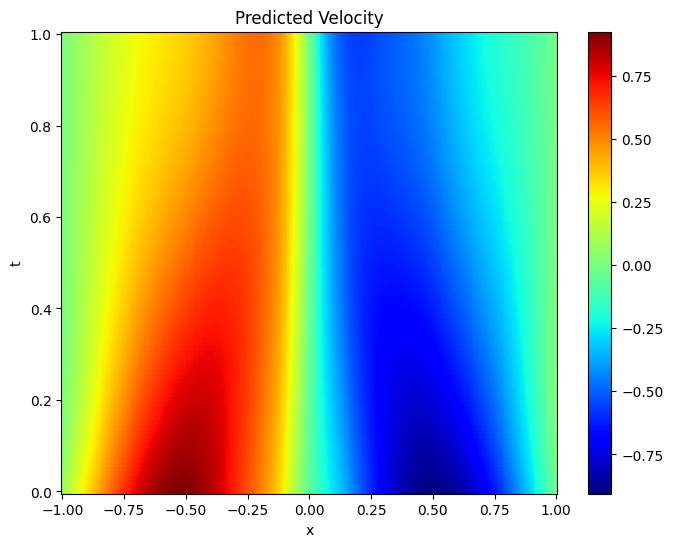

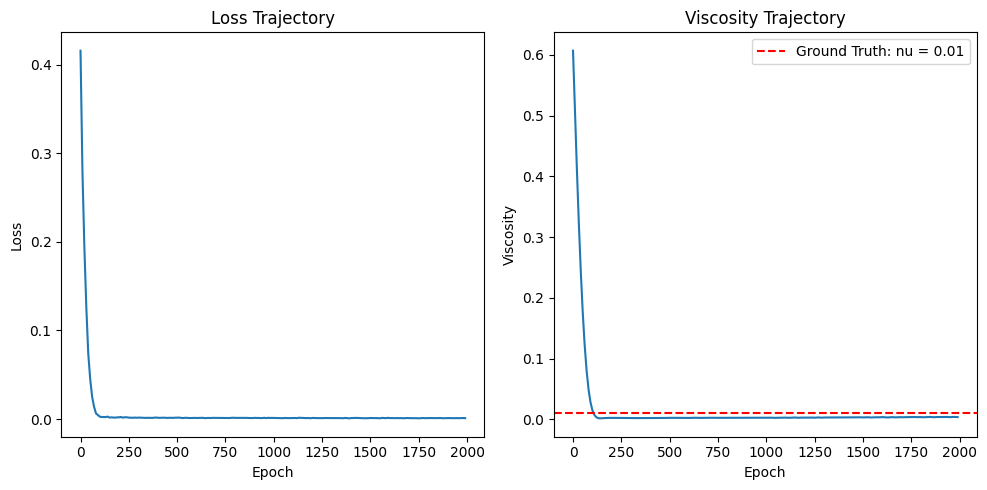

<bound method BaseResourceVariable.numpy of <tf.Variable 'artificial_viscosity:0' shape=() dtype=float32, numpy=0.0041780295>>


In [15]:
# v10 7 Oct 2023 
# artificial viscosity - achieved with TF variables
# made adjustment on IC/BC loss functions

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy
from scipy.interpolate import griddata

# data = scipy.io.loadmat('burgers_shock.mat')
# Exact = data['usol']
# Exact_u = np.real(Exact)

# Define the domain class
class Domain:
    def __init__(self, x_min, x_max, t_min, t_max, num_x, num_t, viscosity_init_v):
        self.x_min = x_min
        self.x_max = x_max
        self.t_min = t_min
        self.t_max = t_max
        self.num_x = num_x
        self.num_t = num_t
        self.viscosity = tf.Variable(initial_value=viscosity_init_v, 
                                     trainable=True, 
                                     dtype=tf.float32,
                                     name="artificial_viscosity")
        # initial value can be tf.random.uniform(shape=(), minval=0.1, maxval=1.0)
    
# Define the initial condition
def initial_condition(domain, x):
    # initial_output = np.where(x > 0, 1, 0)
    initial_output = -np.sin(np.pi * x)
    return initial_output 

# Define the boundary conditions
def boundary_conditions(domain, x_boundary, x, t):
    return np.zeros_like(x)

# Define the physics-informed loss function
def physics_informed_loss(network, domain, x, t, batch_size):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(x)
        tape.watch(t)
        
        u = network(tf.concat([x, t], axis=1))

        u_x = tape.gradient(u, x) # cancel: Reshape x to [32,1]
        u_t = tape.gradient(u, t) # solved: u_t showed NoneType

        # Debugging: Check if any tensors contain NaN values
        tf.debugging.assert_all_finite(u_x, "u_x contains NaN values")
        tf.debugging.assert_all_finite(u_t, "u_t contains NaN values")

        # Define the Burgers equation residual
        residual = u_t + u * u_x - domain.viscosity / np.pi * tape.gradient(u_x, x)
    
    # Define the boundary and initial condition residuals # Done_TODO check "u" LR
    # Compute the loss for initial condition
    num_batch_size_0 = 32
    t_batch_0 = tf.fill([num_batch_size_0, 1], 0.001) # considered as 0
    x_batch_0 = tf.random.uniform([num_batch_size_0, 1], minval=domain.x_min, maxval=domain.x_max)
    u_0 = network(tf.concat([x_batch_0, t_batch_0], axis=1))
    initial_residual = u_0 - initial_condition(domain, x_batch_0)

    # Compute the loss for boundary condition
    num_batch_size_b = 32
    x_batch_bl = tf.cast(tf.fill([num_batch_size_b, 1], -1), dtype=tf.float32)
    x_batch_br = tf.cast(tf.fill([num_batch_size_b, 1], 1), dtype=tf.float32)
    t_batch_b  = tf.random.uniform([num_batch_size_b, 1], minval=domain.t_min, maxval=domain.t_max)
    u_bl = network(tf.concat([x_batch_bl, t_batch_b], axis=1)) # int32 and float incompatible
    u_br = network(tf.concat([x_batch_br, t_batch_b], axis=1))
    lower_boundary_residual = u_bl - boundary_conditions(domain, domain.x_min, x_batch_bl, t_batch_b)
    upper_boundary_residual = u_br - boundary_conditions(domain, domain.x_max, x_batch_br, t_batch_b)

    viscosity_loss = tf.square(domain.viscosity) 

    loss = tf.reduce_mean(tf.square(residual)) / batch_size + \
           tf.reduce_mean(tf.square(initial_residual)) / num_batch_size_0 + \
           tf.reduce_mean(tf.square(lower_boundary_residual)) / num_batch_size_b + \
           tf.reduce_mean(tf.square(upper_boundary_residual)) / num_batch_size_b + \
            viscosity_loss
    
    return loss

# Define the neural network model
def create_network():
    network = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(2,)),
        tf.keras.layers.Dense(32, activation='tanh'),
        tf.keras.layers.Dense(32, activation='tanh'),
        tf.keras.layers.Dense(1)
    ])
    return network

# Train the model using PINNs
def train_model(network, domain, num_epochs, learning_rate, batch_size):
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    # Lists to store loss and viscosity values for each epoch
    loss_history = []
    viscosity_history = []

    for epoch in range(num_epochs):
        x_batch = tf.random.uniform([batch_size, 1], minval=domain.x_min, maxval=domain.x_max)
        t_batch = tf.random.uniform([batch_size, 1], minval=domain.t_min, maxval=domain.t_max)

        with tf.GradientTape() as tape:
            loss = physics_informed_loss(network, domain, x_batch, t_batch, batch_size)

        # add viscosity into the trainable variables from TF
        variable_list = network.trainable_variables + [domain.viscosity]

        gradients = tape.gradient(loss, variable_list)
        optimizer.apply_gradients(zip(gradients, variable_list))

        # try#1 Update the viscosity value during training
        # domain.viscosity.assign(network.layers[-1].weights[0].numpy())

        # try#2
        # Manually update the trainable_viscosity variable based on gradients
        # viscosity_update = tf.reduce_sum(learning_rate * gradients[-1])
        # print("shape of nu:", domain.viscosity)
        # print("update.numpy:", viscosity_update.shape)
        # domain.viscosity.assign_sub(viscosity_update)  # Update the last gradient element

        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss.numpy()}")

        if epoch % 10 == 0:
            # Append the loss and viscosity values to the history lists
            loss_history.append(loss.numpy())
            viscosity_history.append(domain.viscosity.numpy())
    
    return network, loss_history, viscosity_history 
# worked after changing it to "network"
#TODO: showed error: NameError                        Traceback (most recent call last)
# /Users/e0919678/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Desktop/MEng_files/CFD_HPC/Code_TensorDiffEq/burgers_learn_2Oct_v2.ipynb Cell 1 line 1
#     139 network = create_network()
#     141 # Train the model using PINNs
# --> 142 model = train_model(network, domain, num_epochs=2000, learning_rate=0.01, batch_size=32, num_collocation_points=1000)
#     144 # Visualize the results
#     145 visualize_results(model, domain)
# 
# /Users/e0919678/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Desktop/MEng_files/CFD_HPC/Code_TensorDiffEq/burgers_learn_2Oct_v2.ipynb Cell 1 line 1
#     106     if epoch % 100 == 0:
#     107         print(f"Epoch {epoch}, Loss: {loss.numpy()}")
# --> 109 return model
# 
# NameError: name 'model' is not defined

# Visualize the results
def visualize_results(model, domain, loss_history, viscosity_history, num_epochs):
    x_grid, t_grid = np.meshgrid(np.linspace(domain.x_min, domain.x_max, domain.num_x),
                                 np.linspace(domain.t_min, domain.t_max, domain.num_t))
    X = np.hstack((x_grid.flatten()[:, tf.newaxis], t_grid.flatten()[:, tf.newaxis]))
    u_pred_grid = model.predict(X)
    u_pred_grid = griddata(X, u_pred_grid.flatten(), (x_grid, t_grid), method='cubic')

    print("u_pred_shape:", u_pred_grid.shape)

    plt.figure(figsize=(8, 6))
    plt.pcolor(x_grid, t_grid, u_pred_grid, cmap='jet')
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('t')
    plt.title('Predicted Velocity')
    plt.show()

    # Define the x-axis labels at intervals of every 10 epochs
    x_labels = list(range(0, num_epochs, 10))

    # Plot the loss and viscosity trajectories
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x_labels, loss_history)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Trajectory')

    plt.subplot(1, 2, 2)
    plt.plot(x_labels, viscosity_history)
    plt.axhline(y=0.01, color='r', linestyle='--', label='Ground Truth: nu = 0.01')
    plt.xlabel('Epoch')
    plt.ylabel('Viscosity')
    plt.title('Viscosity Trajectory')
    plt.legend()
    plt.tight_layout()
    plt.show()
    return u_pred_grid


if __name__ == "__main__":
    # Define domain parameters and create the domain
    x_min = -1.0
    x_max = 1.0
    t_min = 0
    t_max = 1.00
    num_x = 256
    num_t = 100
    viscosity_init_v = tf.random.uniform(shape=(), minval=0.001, maxval=1.0)
    domain = Domain(x_min, x_max, t_min, t_max, num_x, num_t, viscosity_init_v)
    num_epochs = 2000

    # Create the neural network 
    network = create_network()

    # Train the model using PINNs
    model, loss_history, viscosity_history = train_model(network, 
                                                         domain, 
                                                         num_epochs, 
                                                         learning_rate=0.01, 
                                                         batch_size=256
                                                         )

    # Visualize the results
    u_pred_grid = visualize_results(model, domain, loss_history, viscosity_history, num_epochs)

    print(domain.viscosity.numpy)
